# Import userful parts for preparation

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import seaborn

%matplotlib inline

import urllib.request
urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt','stations.txt')

('stations.txt', <email.message.Message at 0x20dd724d550>)

In [5]:
def parsefile(filename):
    return np.genfromtxt(filename,
                         delimiter = dly_delimiter,
                         usecols = dly_usecols,
                         dtype = dly_dtype,
                         names = dly_names)


dly_delimiter = [11,4,2,4] + [5,1,1,1]*31 
  #from description of readme.txt, see the number of columns according with variable
    
dly_usecols = [1,2,3] + [4*i for i in range(1,32)] 
  #indicate columns we will use, so only (col 0 for ID is skipped) year, month, element and Value(n), each value represent a day
    
dly_dtype = [np.int32, np.int32, (np.str_,4)] + [np.int32] * 31

dly_names = ['year','month','obs'] + [str(day) for day in range(1, 31+1)] 
  #labels of columns used


#Preparation for defining getobs() function
def unroll(record):
    startdate = np.datetime64('{}-{:02}'.format(record['year'],record['month']))
    dates = np.arange(startdate, startdate + np.timedelta64(1,'M'), np.timedelta64(1,'D'))
    
    rows = [(date,record[str(i+1)]/10) for i, date in enumerate(dates)] #enumerate() will assign an index for each observation
    return np.array(rows,dtype=[('date','M8[D]'),('value','d')])


#Function for returning a time series of observations
def getobs(filename, obs):
    return np.concatenate([unroll(row) for row in parsefile(filename) if row[2] == obs])


#Function for cleaning missing data
def getobs(filename, obs):
    data = np.concatenate([unroll(row) for row in parsefile(filename) if row[2] == obs])
    data['value'][data['value'] == -999.9] = np.nan #replace -999.9 with "not a number"
    
    return data

#Fill nan with interpolation value
def fillnans(data):
    dates_float = data['date'].astype(np.float64) #np.astype() helps tranform data types
    
    nan = np.isnan(data['value'])
      #np.isnan() returns boolean masks for points that are indeed nan. 
      #So "nan" is a series containing T/F for each obs in data
        
    data['value'][nan] = np.interp(dates_float[nan], dates_float[~nan], data['value'][~nan]) 
      #"~" denotes negation for Boolean values 

#Selecting data with one certain year
def selectyear(data, year):
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1, 'Y')
    
    return data[(data['date'] >= start) & (data['date'] < end)]['value']

# Find the year with the highest mean TMAX in Minneapolis

In [4]:
Minneapolis_tmax = getobs('USW00014922.dly','TMAX')
fillnans(Minneapolis_tmax)

np.mean(Minneapolis_tmax['value'])

12.74308121666019

In [18]:
#A matrix for all daily records
M_tmax_all = np.vstack([selectyear(Minneapolis_tmax, year)[:365] for year in range(1940, 2014+1)])
M_tmax_all

array([[-13.9, -12.8, -12.2, ...,   1.1,   1.7,   1.1],
       [  1.7,   0.6,  -8.3, ...,  -5.6,  -2.2,  -8.9],
       [ -8.9, -14.4, -15. , ...,  -6.1,  -6.7,  -2.2],
       ...,
       [  1.1,  -6.7,  -1.7, ...,  -3.3,  -7.2,  -3.9],
       [ -6.7,  -6.1,  -5.6, ...,  -6.6, -16.6, -18.2],
       [-17.1, -15.5,  -1.6, ..., -12.1, -15.5, -10.5]])

In [19]:
#A matrix with yearly means
M_tmax_mean = np.mean(M_tmax_all, axis = 1) #Axis=1 indicates only aggregate for each row
M_tmax_mean

array([11.83917808, 13.82547945, 12.75561644, 11.87452055, 13.12520548,
       11.6430137 , 13.43260274, 12.54328767, 13.36410959, 13.54219178,
       10.8569863 , 10.44876712, 12.80109589, 13.64356164, 12.78493151,
       12.96191781, 12.65589041, 12.49863014, 13.10438356, 12.94986301,
       12.18849315, 12.48767123, 11.22136986, 12.85616438, 13.30027397,
       11.0890411 , 11.89205479, 11.47780822, 12.64821918, 12.27178082,
       12.07945205, 12.01835616, 10.28465753, 13.11643836, 12.26849315,
       12.26465753, 13.88438356, 12.65945205, 12.21123288, 11.47726027,
       12.87780822, 13.33589041, 12.05726027, 12.1709589 , 12.2860274 ,
       11.75835616, 12.51917808, 15.14986301, 13.84164384, 12.12493151,
       14.04356164, 12.83013699, 12.28273973, 11.29589041, 12.78767123,
       12.55753425, 11.15534247, 12.08328767, 14.54383562, 14.02438356,
       12.90739726, 13.54109589, 12.88109589, 12.93671233, 12.8539726 ,
       13.77972603, 14.43068493, 13.70465753, 12.10739726, 12.33

In [20]:
years = np.arange(1940, 2014+1)

In [21]:
M_tmax_year = years[np.argmax(M_tmax_mean)]
M_tmax_year

2012

So 2012 is the year with the highest mean TMAX in Minneapolis!

# Find the year with the lowest mean TMIN in San Diego

In [22]:
SD_tmin = getobs('USW00023188.dly','TMIN')
fillnans(SD_tmin)

SD_tmin_all = np.vstack([selectyear(SD_tmin, year)[:365] for year in range(1940, 2014+1)])
SD_tmin_mean = np.mean(SD_tmin_all, axis = 1)

SD_tmin_year = years[np.argmin(SD_tmin_mean)]
SD_tmin_year

1948

# Show TMIN and TMAX throughout those years for those cities

(-17.2, 365, -18.325, 41.625)

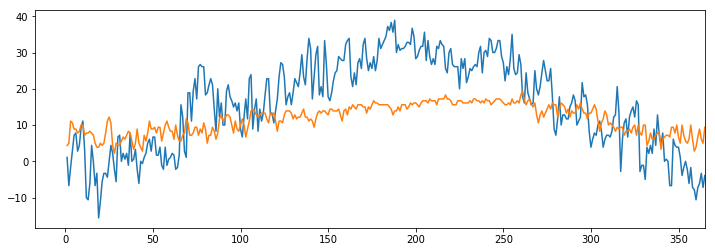

In [27]:
days = np.arange(1,365+1)

pp.figure(figsize=(12,4))

pp.plot(days, selectyear(Minneapolis_tmax, 2012)[:365])
pp.plot(days, selectyear(SD_tmin, 1948)[:365])

pp.axis(xmax=365)